In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler

In [2]:
x = []
y = []
with open("linsep.txt", "r") as fp:
    lines = fp.readlines()
    for line in lines:
        x1, x2, label = line.split(",")
        x.append([x1, x2])
        y.append(int(label))
x = np.array(x)
y = np.array(y)

In [3]:
labels = np.array([1 if x == 1 else 0 for x in y])

In [4]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [5]:
type(y[0])

numpy.int32

In [6]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#Initializing values and computing H. Note the 1. to force to float type
m,n = x.shape
y = y.reshape(-1,1) * 1.
X_dash = y * x
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#w parameter in vectorized form
w = ((y * alphas).T @ x).reshape(-1,1).flatten()

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(x[S], w)
b = b[0]
#Display results
# print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w)
print('b = ', b[0])

w =  [ 2.10657525 -1.06619998]
b =  1.993113802127188


In [7]:
slope = -w[0]/w[1]
intercept = b[0]
print("Slope: ", slope)
print("Intercept: ", intercept)
print("Slope-Intercept Equation of line (hyper-plane in our case): y = m * x + c\nEquation of Plane: y = ", slope, "* x + ", intercept)
print("General Equation of line (hyper-plane in our case): Ax + By + c = 0\nEquation of Plane: ", slope, "* x + -1 * y + ", intercept, )

Slope:  1.9757787449100916
Intercept:  1.993113802127188
Slope-Intercept Equation of line (hyper-plane in our case): y = m * x + c
Equation of Plane: y =  1.9757787449100916 * x +  1.993113802127188
General Equation of line (hyper-plane in our case): Ax + By + c = 0
Equation of Plane:  1.9757787449100916 * x + -1 * y +  1.993113802127188


In [8]:
# svm = HardMarginSVM()
# svm.fit(x,y)
# slope = -svm.w[0]/svm.w[1]
# intercept = svm.b
# print("Slope: ", slope)
# print("Intercept: ", intercept)
# print("Slope-Intercept Equation of line (hyper-plane in our case): y = m * x + c\nEquation of Plane: y = ", slope[0], "* x + ", intercept)
# print("General Equation of line (hyper-plane in our case): Ax + By + c = 0\nEquation of Plane: ", slope[0], "* x + -1 * y + ", intercept, )

In [9]:
def shortest_distance(x1, y1, a, b, c): 
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d

In [10]:
support_vectors_pos = []
support_vectors_neg = []
pos_dists = []
neg_dists = []
a = slope
b = -1
c = intercept
min_dist_pos = np.inf
min_dist_neg = np.inf 
for idx, point in enumerate(x):
    x1 = point[0]
    x2 = point[1]
    dist = shortest_distance(x1, x2, a, b, c)
    if y[idx] == 1:
        pos_dists.append(dist)
        if dist <= min_dist_pos:
            if dist < min_dist_pos:
                support_vectors_pos = [point]
                min_dist_pos = dist
            else:
                support_vectors_pos.append(point)
    else:
        neg_dists.append(dist)
        if dist <= min_dist_neg:
            if dist < min_dist_neg:
                support_vectors_neg = [point]
                min_dist_neg = dist
            else:
                support_vectors_neg.append(point)
support_vectors = support_vectors_pos + support_vectors_neg
support_vectors = np.array(support_vectors)
print("Support Vectors: ", support_vectors)

Support Vectors:  [[-1.06434095 -1.17145051]
 [-1.85292051 -0.85368853]]


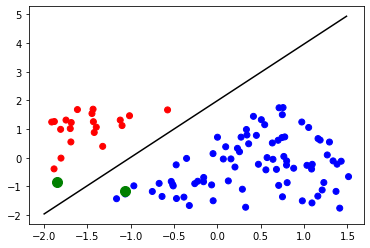

In [11]:
import matplotlib.pyplot as plt
colormap = np.array(['r', 'b'])
axes = plt.gca()
x_vals = np.array(list(np.arange(-2.0, 1.5, 0.01)))
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', c = 'black')
plt.scatter(x[:,0], x[:,1], c = colormap[labels])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c = 'green', s = 100)

In [12]:
x_non = []
y_non = []
with open("nonlinsep.txt", "r") as fp:
    lines = fp.readlines()
    for line in lines:
        x1, x2, label = line.split(",")
        x_non.append([x1, x2])
        y_non.append(int(label))
x_non = np.array(x_non)
y_non = np.array(y_non)

In [13]:
scaler_non = StandardScaler()
x_non = scaler_non.fit_transform(x_non)

In [14]:
labels_non = np.array([1 if x == 1 else 0 for x in y_non])

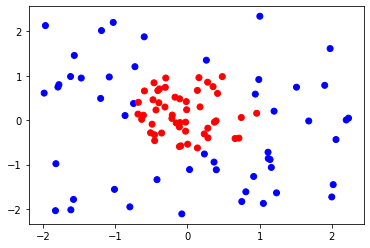

In [15]:
plt.close()
plt.scatter(x_non[:,0], x_non[:,1], c = colormap[labels_non])

In [16]:
import cvxopt

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

class SVM:
    def __init__(self, kernel=polynomial, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])
        # print(self.alphas)

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

In [17]:
svm = SVM(kernel=polynomial)
svm.fit(x_non, y_non)
sv = svm.get_parameters(svm.alphas)

In [21]:
print("w = ", svm.w)
print("b = ", svm.b)

w =  [[-0.04045736]
 [-0.22288251]]
b =  -3.302871325291265


In [18]:
support_vectors = []
for idx, item in enumerate(sv):
    if item == True:
        support_vectors.append(x_non[idx])
support_vectors = np.array(support_vectors)
print("Support Vectors: ", support_vectors)

Support Vectors:  [[-0.86418555  0.10399898]
 [-0.74696768  0.37436577]
 [ 0.26211456  1.34821547]
 [ 0.23463737 -0.76037688]
 [ 0.94034625  0.58562646]
 [-0.68575217  0.13641437]
 [-0.67983439  0.40074791]
 [ 0.13836617 -0.62470348]
 [ 0.9591535   0.15514729]
 [ 0.48287282  0.97976922]]


In [19]:
slope = -svm.w[0]/svm.w[1]
intercept = svm.b
print("Slope: ", slope)
print("Intercept: ", intercept)
print("Slope-Intercept Equation of line (hyper-plane in our case): y = m * x + c\nEquation of Plane: y = ", slope[0], "* x + ", intercept)
print("General Equation of line (hyper-plane in our case): Ax + By + c = 0\nEquation of Plane: ", slope[0], "* x + -1 * y + ", intercept, "= 0")
print("A = ", slope[0], ", B = ", -1, ", c = ", intercept)

Slope:  [-0.18151879]
Intercept:  -3.302871325291265
Slope-Intercept Equation of line (hyper-plane in our case): y = m * x + c
Equation of Plane: y =  -0.18151878627296889 * x +  -3.302871325291265
General Equation of line (hyper-plane in our case): Ax + By + c = 0
Equation of Plane:  -0.18151878627296889 * x + -1 * y +  -3.302871325291265 = 0
A =  -0.18151878627296889 , B =  -1 , c =  -3.302871325291265


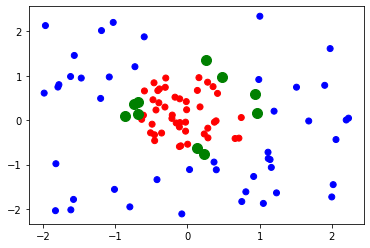

In [20]:
plt.close()
plt.scatter(x_non[:,0], x_non[:,1], c = colormap[labels_non])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c = 'green', s = 100)